In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns

In [47]:
df = pd.read_csv('crimedata.csv')
df.dtypes

DR_NO               int64
Date Rptd          object
DATE OCC           object
TIME OCC            int64
AREA                int64
AREA NAME          object
Rpt Dist No         int64
Part 1-2            int64
Crm Cd              int64
Crm Cd Desc        object
Mocodes            object
Vict Age            int64
Vict Sex           object
Vict Descent       object
Premis Cd         float64
Premis Desc        object
Weapon Used Cd    float64
Weapon Desc        object
Status             object
Status Desc        object
Crm Cd 1          float64
Crm Cd 2          float64
Crm Cd 3          float64
Crm Cd 4          float64
LOCATION           object
Cross Street       object
LAT               float64
LON               float64
dtype: object

## Pick relevant Columns

In [48]:
df1 = df[['DATE OCC', 'AREA NAME', 'Crm Cd Desc', 'Vict Age', 'Vict Sex', 'Vict Descent', 'LAT',
       'LON']]
df1

,DATE OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,LAT,LON
0,01/08/2020 12:00:00 AM,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,34.0141,-118.2978
1,01/01/2020 12:00:00 AM,Central,BATTERY - SIMPLE ASSAULT,25,M,H,34.0459,-118.2545
2,02/13/2020 12:00:00 AM,Central,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,34.0448,-118.2474
3,01/01/2020 12:00:00 AM,N Hollywood,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,34.1685,-118.4019
4,01/01/2020 12:00:00 AM,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,34.2198,-118.4468
...,...,...,...,...,...,...,...,...
708079,01/08/2023 12:00:00 AM,West LA,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",48,M,O,34.0611,-118.4184
708080,01/26/2023 12:00:00 AM,Foothill,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",23,M,H,34.2466,-118.4054
708081,03/22/2023 12:00:00 AM,Foothill,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",25,F,H,34.2790,-118.4116
708082,04/12/2023 12:00:00 AM,77th Street,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",29,M,B,33.9841,-118.2915


In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708084 entries, 0 to 708083
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DATE OCC      708084 non-null  object 
 1   AREA NAME     708084 non-null  object 
 2   Crm Cd Desc   708084 non-null  object 
 3   Vict Age      708084 non-null  int64  
 4   Vict Sex      615442 non-null  object 
 5   Vict Descent  615436 non-null  object 
 6   LAT           708084 non-null  float64
 7   LON           708084 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 43.2+ MB


## Handling missing / incorrect Values

In [50]:
df1['Vict Sex'].value_counts()

Vict Sex
M    293879
F    261903
X     59578
H        82
Name: count, dtype: int64

In [51]:
# calculate original value counts and percentages
value_counts = df1['Vict Sex'].value_counts()
original_percents = value_counts / len(df1) * 100

# calculate percent of missing values
missing_percents = df1['Vict Sex'].isna().sum() / len(df1) * 100

# calculate adjusted percentages for non-missing values
adjusted_percents = (original_percents / (100 - missing_percents)) * 100

# generate new values to fill missing values
new_values = []
for value, adjusted_percent in adjusted_percents.items():
    count = round((adjusted_percent / 100) * (len(df1) - df1['Vict Sex'].isna().sum()))
    new_values.extend([value] * count)

# fill in missing values with new values
df1['Vict Sex'].fillna(pd.Series(new_values), inplace=True)

# check new value counts and percentages
new_value_counts = df1['Vict Sex'].value_counts()
new_percents = new_value_counts / len(df1) * 100
print(new_percents)

Vict Sex
M    46.900791
F    41.888392
X     9.501415
H     0.013558
Name: count, dtype: float64


C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\2310821325.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Vict Sex'].fillna(pd.Series(new_values), inplace=True)


In [52]:
def transform_sex(df, col):
    # Calculate the proportions of M, F, X, and H values in the column
    proportions = df[col].value_counts(normalize=True)

    # Calculate the proportion of X and H values combined
    xh_proportion = proportions.get('X', 0) + proportions.get('H', 0)

    # Calculate the proportion of M and F values combined
    mf_proportion = proportions.get('M', 0) + proportions.get('F', 0)

    # Calculate the proportion of M and F values based on the remaining proportion after removing X and H
    mf_proportion_new = mf_proportion / (1 - xh_proportion)

    # Replace X and H values with M or F based on the new proportion
    df[col].replace({'X': 'M' if np.random.random() < mf_proportion_new else 'F',
                     'H': 'M' if np.random.random() < mf_proportion_new else 'F'}, inplace=True)

In [53]:
transform_sex(df1, "Vict Sex")

C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\300892090.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col].replace({'X': 'M' if np.random.random() < mf_proportion_new else 'F',


In [54]:
# calculate original value counts and percentages
value_counts = df1['Vict Sex'].value_counts()
original_percents = value_counts / len(df1) * 100

# calculate percent of missing values
missing_percents = df1['Vict Sex'].isna().sum() / len(df1) * 100

# check for null values in the calculations
if original_percents.isnull().any() or np.isnan(missing_percents) or adjusted_percents.isnull().any():
    print("Error: null values detected in value counts or percentages.")
else:
    # calculate adjusted percentages for non-missing values
    adjusted_percents = (original_percents / (100 - missing_percents)) * 100

    # generate new values to fill missing values
    new_values = []
    for value, adjusted_percent in adjusted_percents.items():
        count = round((adjusted_percent / 100) * (len(df1) - df1['Vict Sex'].isna().sum()))
        new_values.extend([value] * count)

    # fill in missing values with new values
    df1['Vict Sex'].fillna(pd.Series(new_values), inplace=True)

    # check new value counts and percentages
    new_value_counts = df1['Vict Sex'].value_counts()
    new_percents = new_value_counts / len(df1) * 100
    print(new_percents)

Vict Sex
M    56.415764
F    43.364629
Name: count, dtype: float64


C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\3519865420.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Vict Sex'].fillna(pd.Series(new_values), inplace=True)


In [55]:
# calculate original value counts and percentages
value_counts_descent = df1['Vict Descent'].value_counts()
original_percents_descent = value_counts_descent / len(df1) * 100

# calculate percent of missing values
missing_percents_descent = df1['Vict Descent'].isna().sum() / len(df1) * 100

# check for null values in the calculations
if original_percents_descent.isnull().any() or np.isnan(missing_percents_descent):
    print("Error: null values detected in value counts or percentages.")
else:
    # calculate adjusted percentages for non-missing values
    adjusted_percents_descent = (original_percents_descent / (100 - missing_percents_descent)) * 100

    # generate new values to fill missing values
    new_values_descent = []
    for value, adjusted_percent in adjusted_percents_descent.items():
        count = round((adjusted_percent / 100) * (len(df1) - df1['Vict Descent'].isna().sum()))
        new_values_descent.extend([value] * count)

    # fill in missing values with new values
    df1['Vict Descent'].fillna(pd.Series(new_values_descent), inplace=True)

    # check new value counts and percentages
    new_value_counts_descent = df1['Vict Descent'].value_counts()
    new_percents_descent = new_value_counts_descent / len(df1) * 100
    print(new_percents_descent)

Vict Descent
H    34.694330
W    23.369685
B    16.310494
X    10.564283
O     8.933121
A     2.453946
K     0.587360
F     0.465058
C     0.414358
J     0.157044
V     0.109168
I     0.109168
Z     0.054937
P     0.029516
U     0.022314
D     0.007626
G     0.007485
S     0.006779
L     0.006779
-     0.000141
Name: count, dtype: float64


C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\604658569.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Vict Descent'].fillna(pd.Series(new_values_descent), inplace=True)


In [56]:
# calculate original value counts and percentages
value_counts_descent = df1['Vict Descent'].value_counts()
# original_percents_descent = value_counts_descent / len(df1) * 100

# calculate percent of missing values
missing_percents_descent = df1['Vict Descent'].isna().sum() / len(df1) * 100

# check for null values in the calculations
if original_percents_descent.isnull().any() or np.isnan(missing_percents_descent):
    print("Error: null values detected in value counts or percentages.")
else:
    # calculate adjusted percentages for non-missing values
    adjusted_percents_descent = (original_percents_descent / (100 - missing_percents_descent)) * 100

    # generate new values to fill missing values
    new_values_descent = []
    for value, adjusted_percent in adjusted_percents_descent.items():
        count = round((adjusted_percent / 100) * (len(df1) - df1['Vict Descent'].isna().sum()))
        new_values_descent.extend([value] * count)

    # fill in missing values with new values
    df1['Vict Descent'].fillna(pd.Series(new_values_descent), inplace=True)

    # check new value counts and percentages
    new_value_counts_descent = df1['Vict Descent'].value_counts()
    new_percents_descent = new_value_counts_descent / len(df1) * 100
    
    # fill any remaining null values with most common value
    if df1['Vict Descent'].isna().sum() > 0:
        most_common_value = new_value_counts_descent.index[0]
        df1['Vict Descent'].fillna(most_common_value, inplace=True)
    
    print(new_percents_descent)

Vict Descent
H    34.694330
W    23.369685
B    16.310494
X    10.564283
O     8.933121
A     2.453946
K     0.587360
F     0.465058
C     0.414358
J     0.157044
V     0.109168
I     0.109168
Z     0.054937
P     0.029516
U     0.022314
D     0.007626
G     0.007485
S     0.006779
L     0.006779
-     0.000141
Name: count, dtype: float64


C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\1745396236.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Vict Descent'].fillna(pd.Series(new_values_descent), inplace=True)
C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\1745396236.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Vict Descent'].fillna(most_common_value, inplace=True)


In [57]:
df1.dropna(inplace=True)

C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\3614008390.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(inplace=True)


In [58]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 706529 entries, 0 to 708083
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DATE OCC      706529 non-null  object 
 1   AREA NAME     706529 non-null  object 
 2   Crm Cd Desc   706529 non-null  object 
 3   Vict Age      706529 non-null  int64  
 4   Vict Sex      706529 non-null  object 
 5   Vict Descent  706529 non-null  object 
 6   LAT           706529 non-null  float64
 7   LON           706529 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 48.5+ MB


# Renaming Columns

In [59]:
df1.rename(columns={
    'DATE OCC': 'Date',
    'AREA NAME': 'Area',
    'Crm Cd Desc': 'crime_commited',
    'Vict Sex': 'Victim_sex',
    'Vict Age': 'Victim_age',
    'Vict Descent': 'Ethnicy'
}, inplace=True)

C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\2273934800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={


In [60]:
df1['Victim_age'].describe()

count    706529.000000
mean         30.014236
std          21.679117
min          -2.000000
25%          13.000000
50%          31.000000
75%          45.000000
max         120.000000
Name: Victim_age, dtype: float64

# Outlier Treatment

In [61]:
anomalies = []
def find_outliers(df):
     
    clmn_std = statistics.stdev(df)
    clmn_mean = statistics.mean(df)
    
    ol_start = clmn_std * 3
    
    lower_limit = clmn_mean - clmn_std
    upper_limit = clmn_mean + clmn_std
    
    for outlier in df:
        if outlier < lower_limit or outlier > upper_limit:
            anomalies.append(outlier)
    return anomalies

In [62]:
find_outliers(df1.Victim_age)
df1 = df1[df1.Victim_age.isin(anomalies) == False]

In [63]:
df1['Victim_age'].min()

9

# Datetime Transformation

In [64]:
df1['Date'] = pd.to_datetime(df1['Date'])

C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\1148610173.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Date'] = pd.to_datetime(df1['Date'])
C:\Users\Emilio\AppData\Local\Temp\ipykernel_5896\1148610173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date'] = pd.to_datetime(df1['Date'])


In [65]:
df1.head()

,Date,Area,crime_commited,Victim_age,Victim_sex,Ethnicy,LAT,LON
0,2020-01-08,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,34.0141,-118.2978
1,2020-01-01,Central,BATTERY - SIMPLE ASSAULT,25,M,H,34.0459,-118.2545
4,2020-01-01,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,M,X,34.2198,-118.4468
5,2020-01-01,Central,"RAPE, FORCIBLE",25,F,H,34.0452,-118.2534
6,2020-01-02,Central,SHOPLIFTING - PETTY THEFT ($950 & UNDER),23,M,H,34.0483,-118.2631


In [66]:
df1['Victim_sex'].value_counts()

Victim_sex
M    207536
F    203980
Name: count, dtype: int64

In [67]:
df1.to_csv('cleaned_crime_data.csv', index=False) 

## End of Data Cleaning

## Start of Exploratory Data Analysis

In [68]:
cd = pd.read_csv('cleaned_crime_data.csv')

In [69]:
cd.head()

,Date,Area,crime_commited,Victim_age,Victim_sex,Ethnicy,LAT,LON
0,2020-01-08,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,34.0141,-118.2978
1,2020-01-01,Central,BATTERY - SIMPLE ASSAULT,25,M,H,34.0459,-118.2545
2,2020-01-01,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,M,X,34.2198,-118.4468
3,2020-01-01,Central,"RAPE, FORCIBLE",25,F,H,34.0452,-118.2534
4,2020-01-02,Central,SHOPLIFTING - PETTY THEFT ($950 & UNDER),23,M,H,34.0483,-118.2631


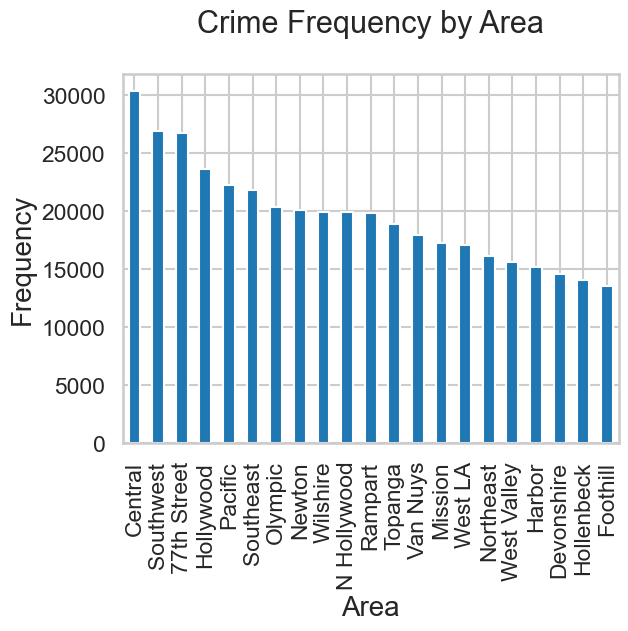

In [70]:
area_counts = cd['Area'].value_counts()

# Plot the bar chart
area_counts.plot(kind='bar')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Crime Frequency by Area')
plt.show()

In [71]:
cd['crime_commited'].value_counts()

crime_commited
BATTERY - SIMPLE ASSAULT                          39695
BURGLARY FROM VEHICLE                             35321
THEFT OF IDENTITY                                 34426
INTIMATE PARTNER - SIMPLE ASSAULT                 32002
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    30873
                                                  ...  
BIGAMY                                                2
GRAND THEFT / INSURANCE FRAUD                         1
THEFT, COIN MACHINE - GRAND ($950.01 & OVER)          1
LYNCHING - ATTEMPTED                                  1
BLOCKING DOOR INDUCTION CENTER                        1
Name: count, Length: 132, dtype: int64

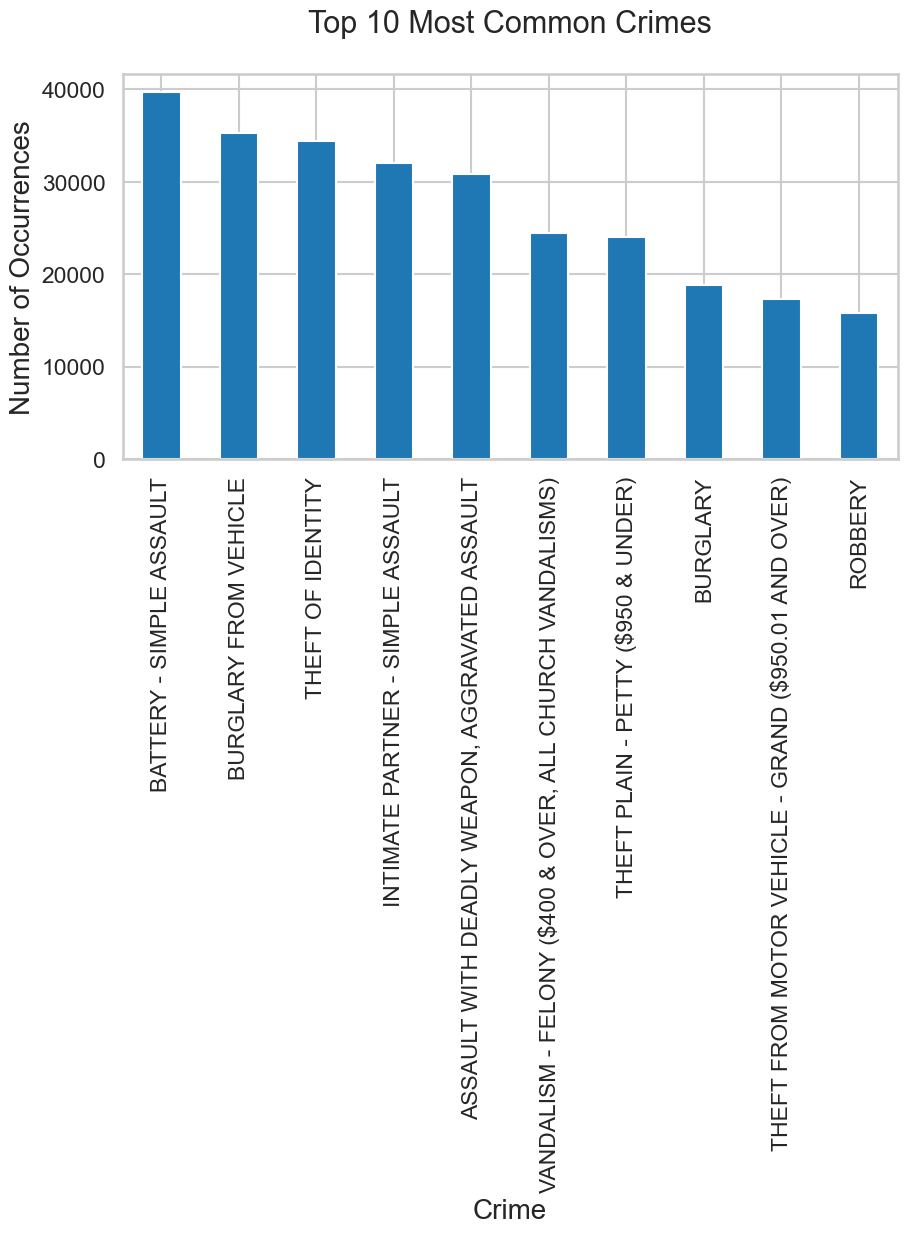

In [72]:
cd['crime_commited'].value_counts().nlargest(10).plot(kind='bar', figsize=(10,5))
plt.title("Top 10 Most Common Crimes")
plt.xlabel("Crime")
plt.ylabel("Number of Occurrences")
plt.show()


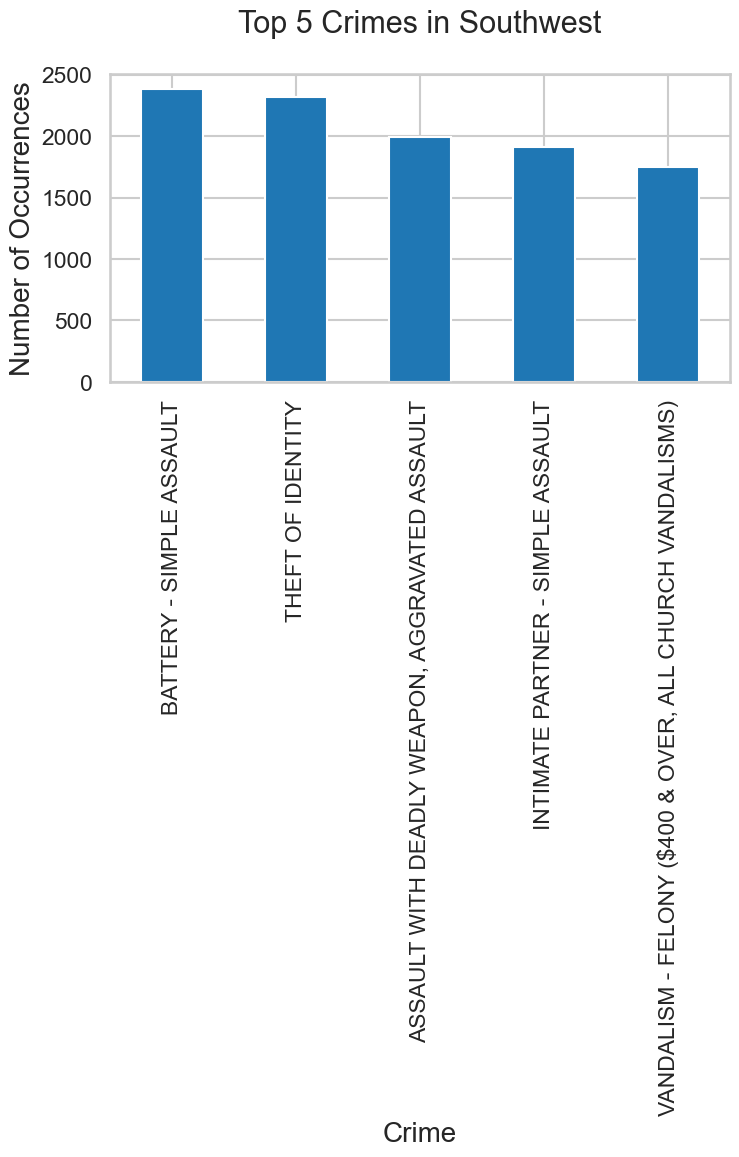

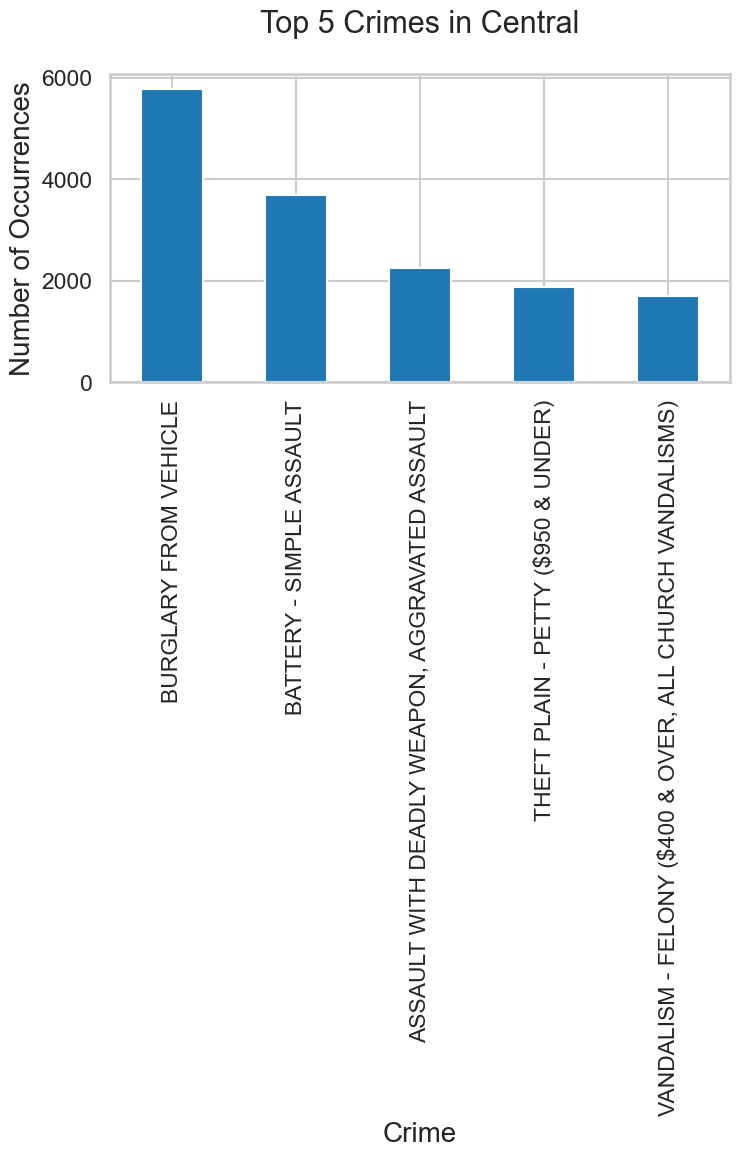

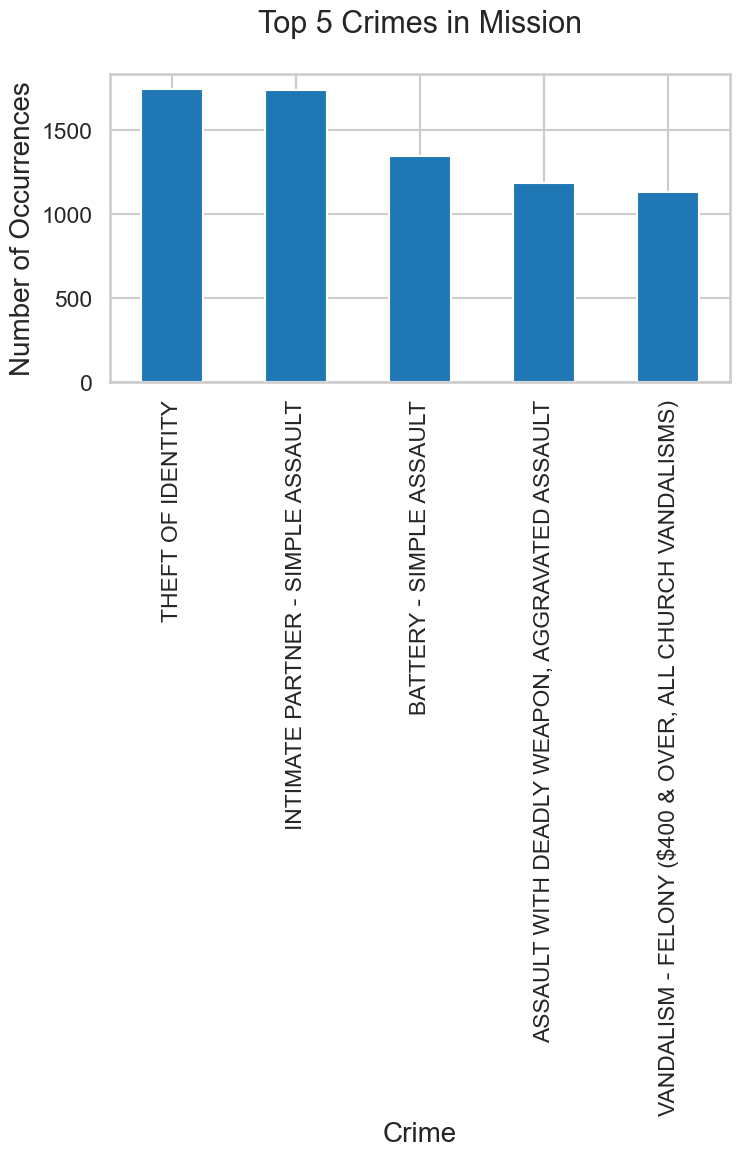

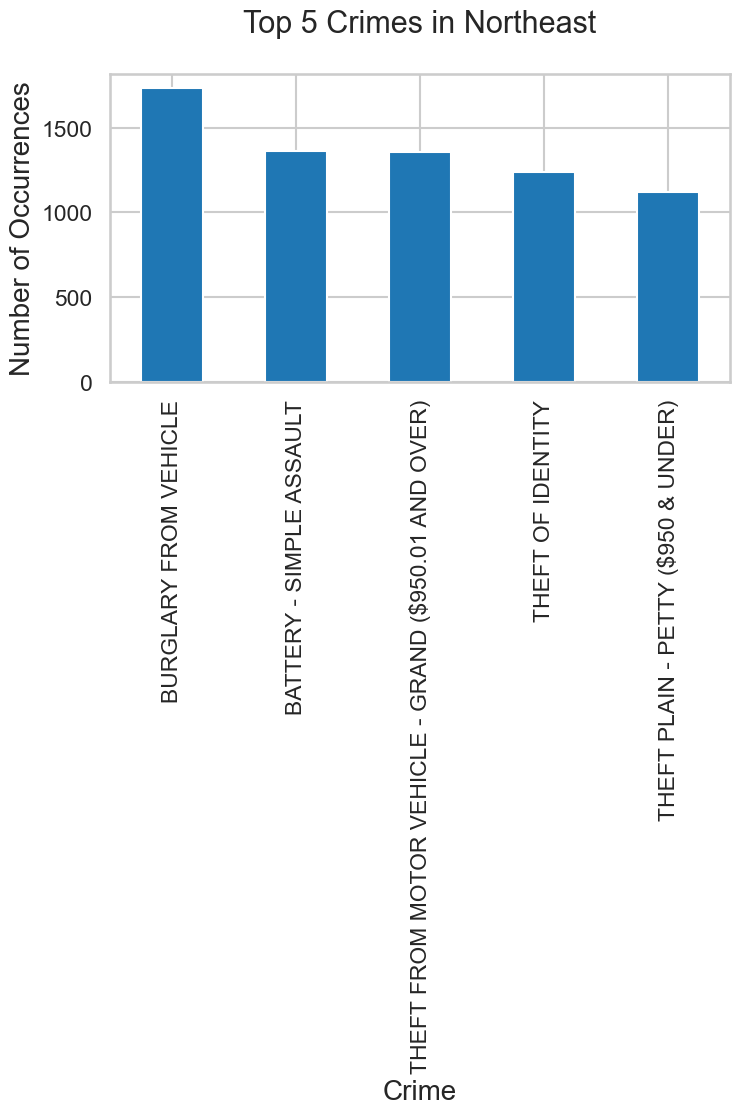

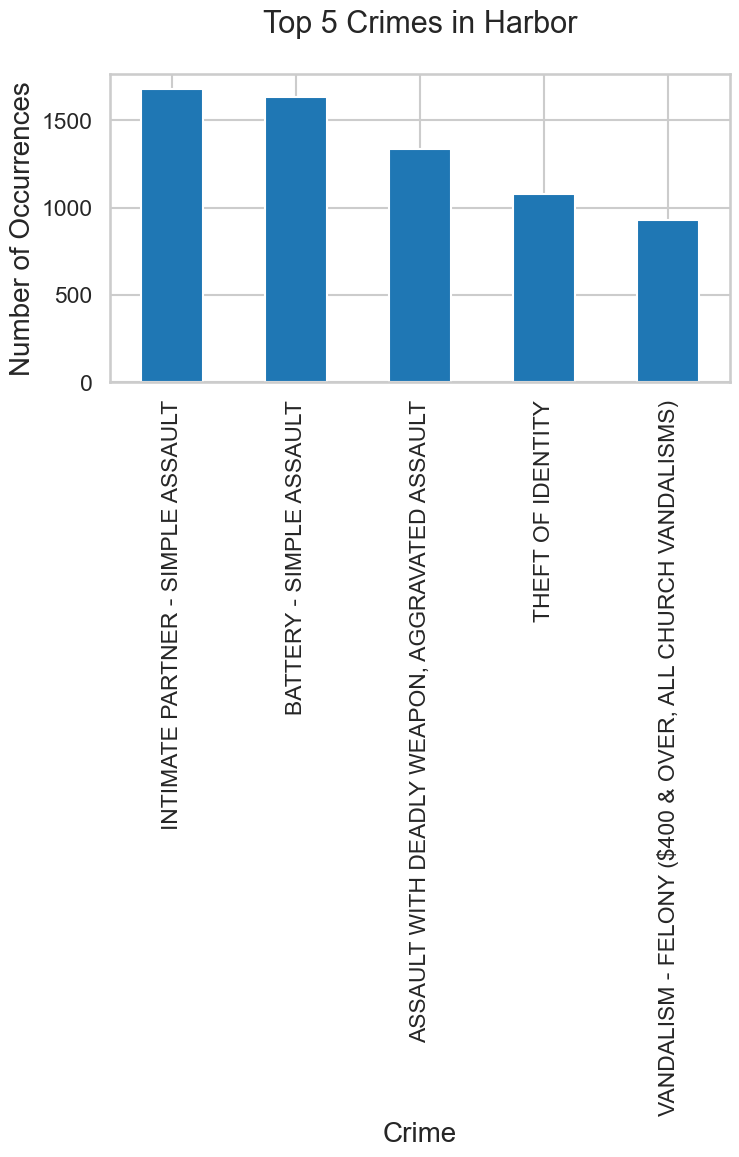

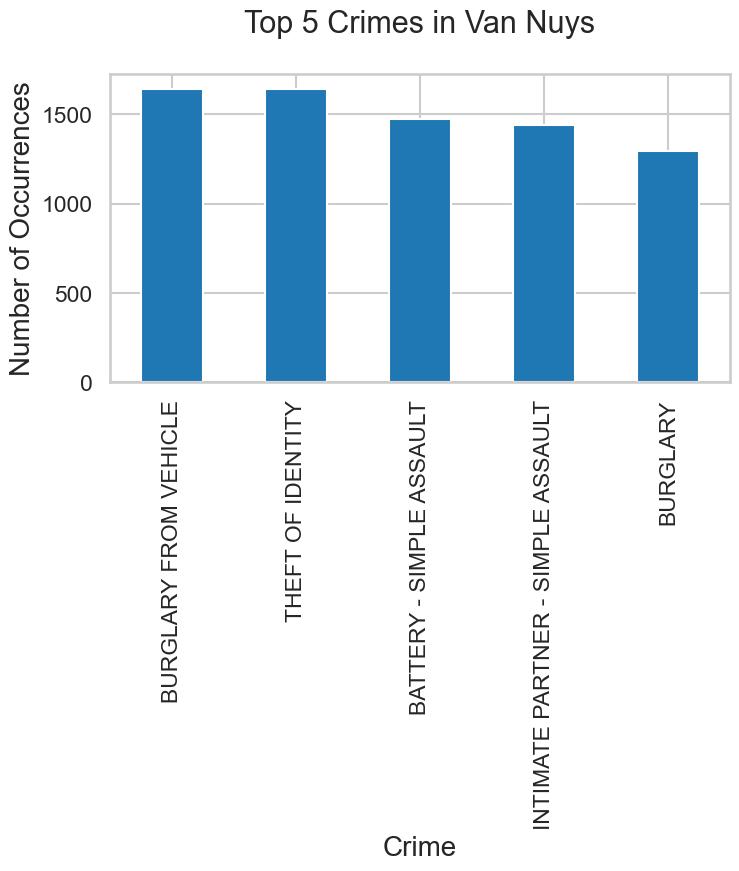

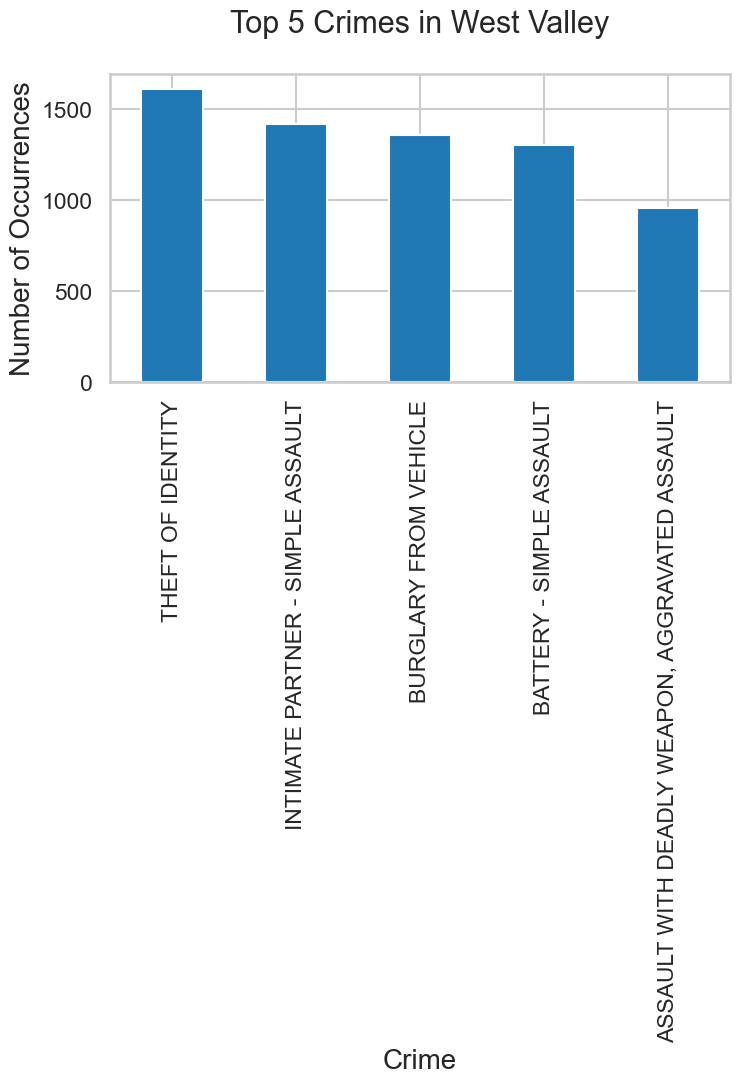

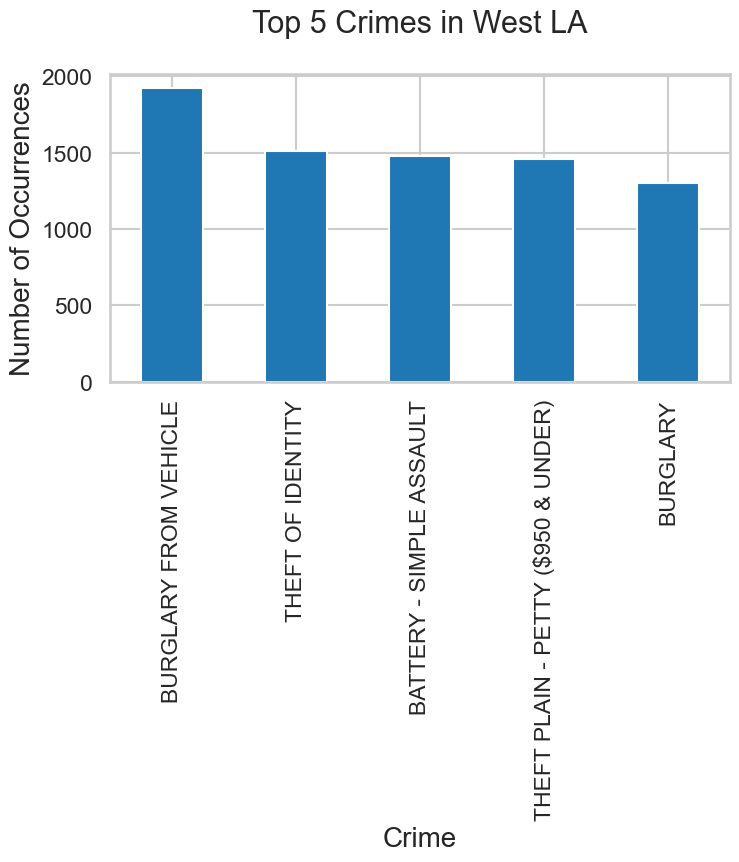

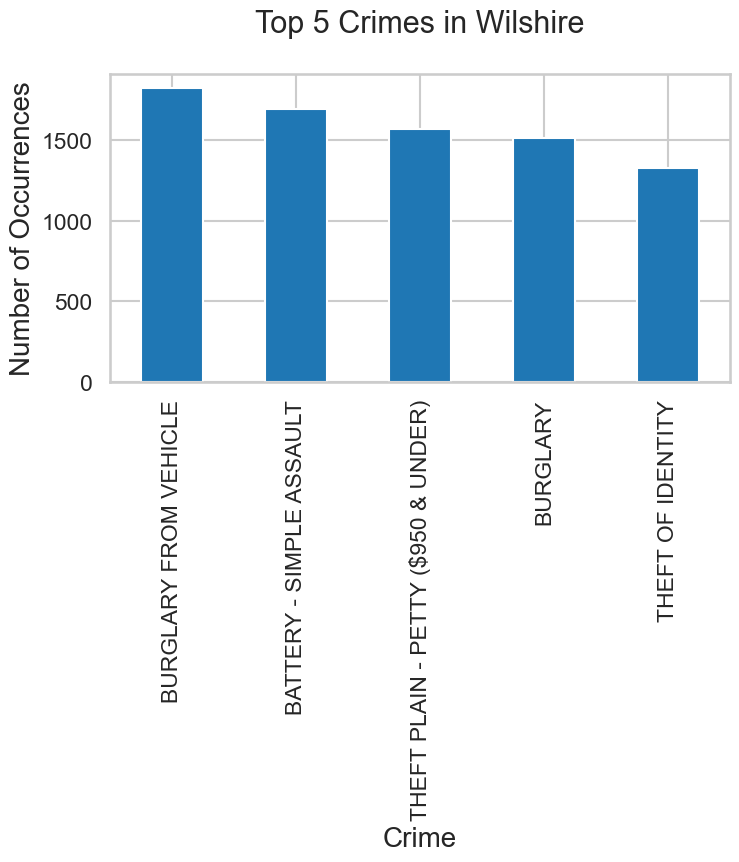

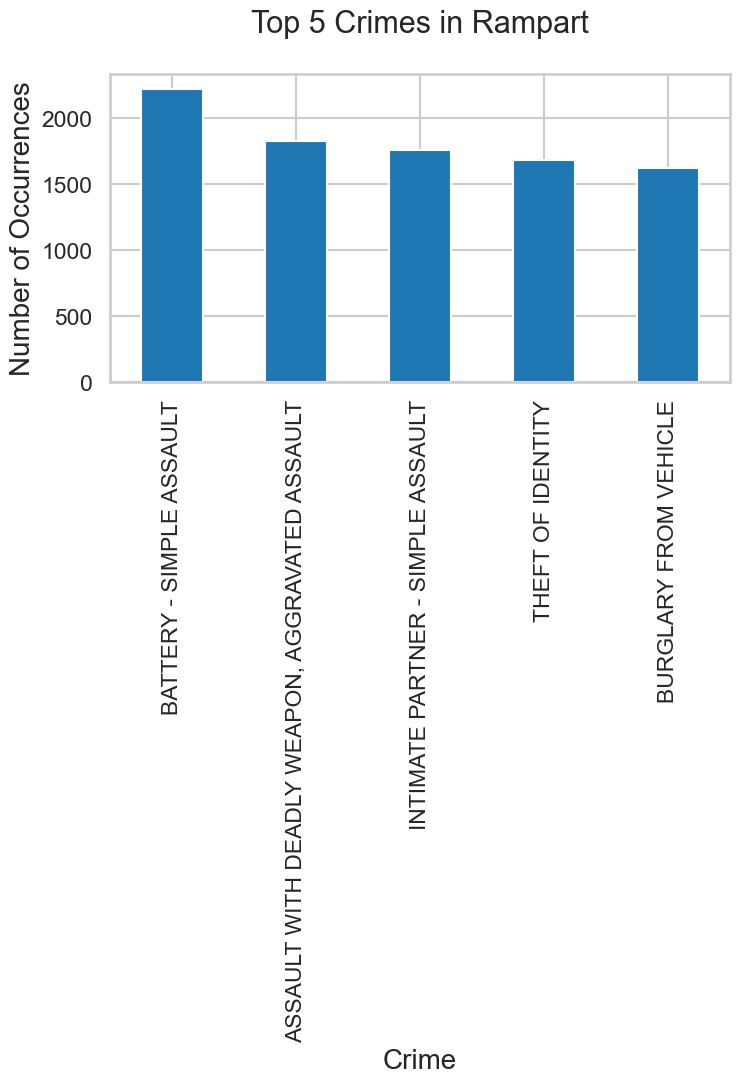

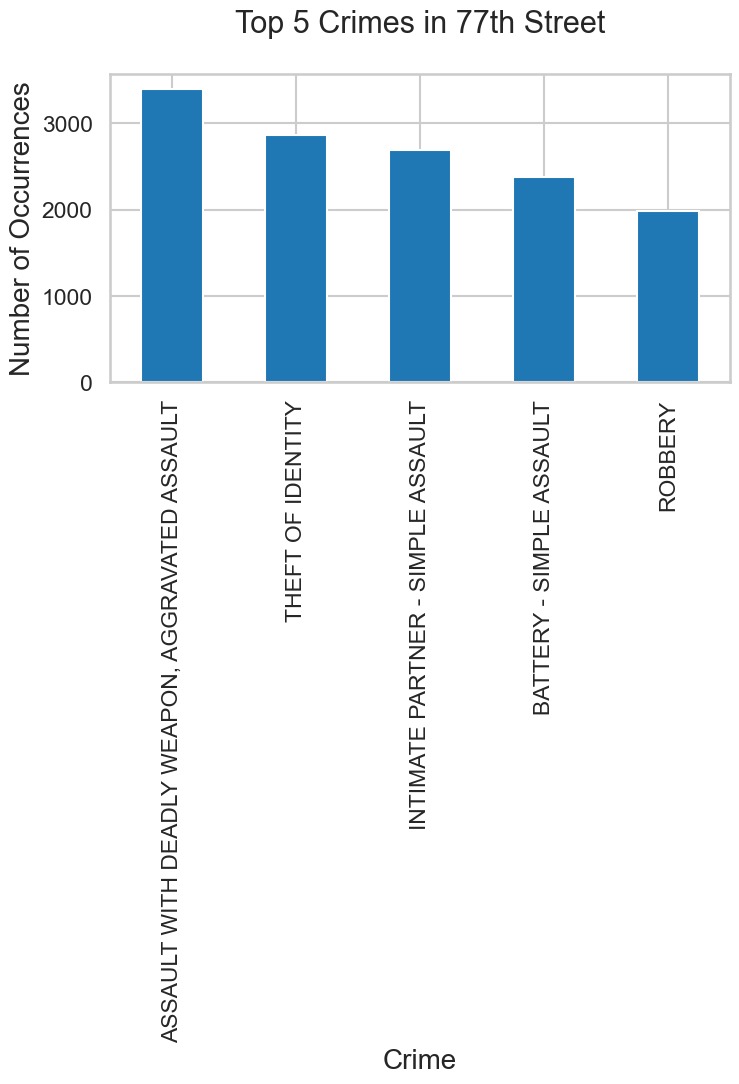

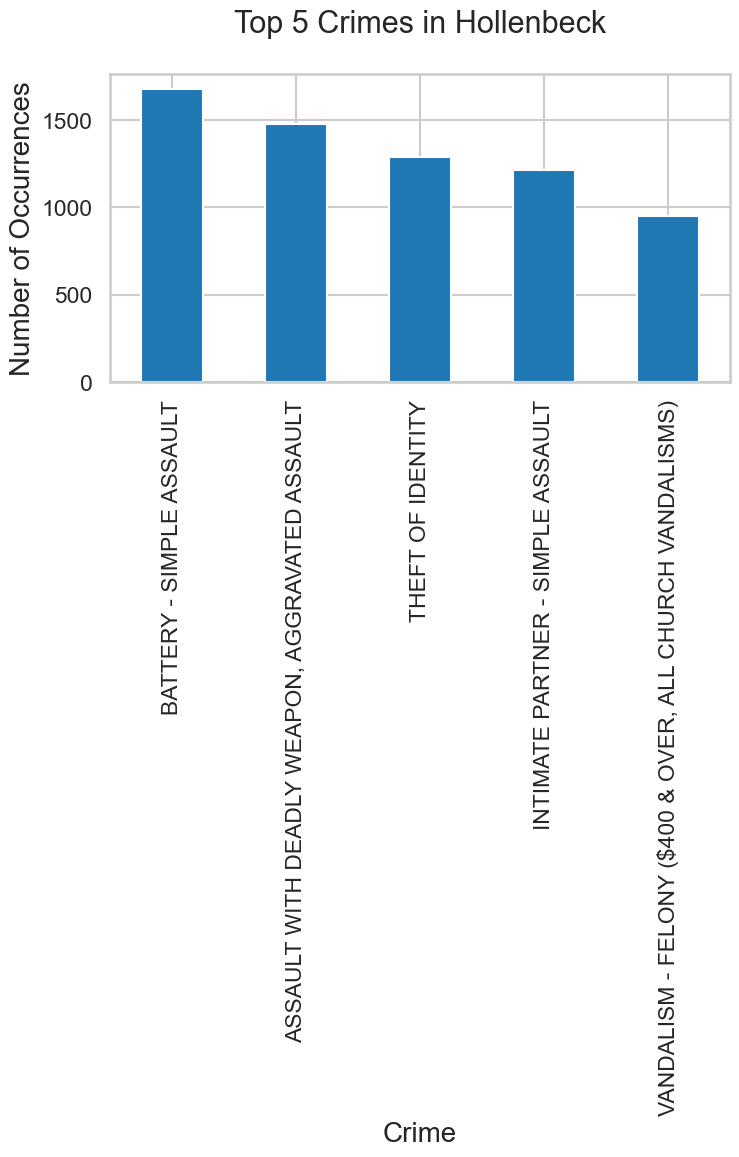

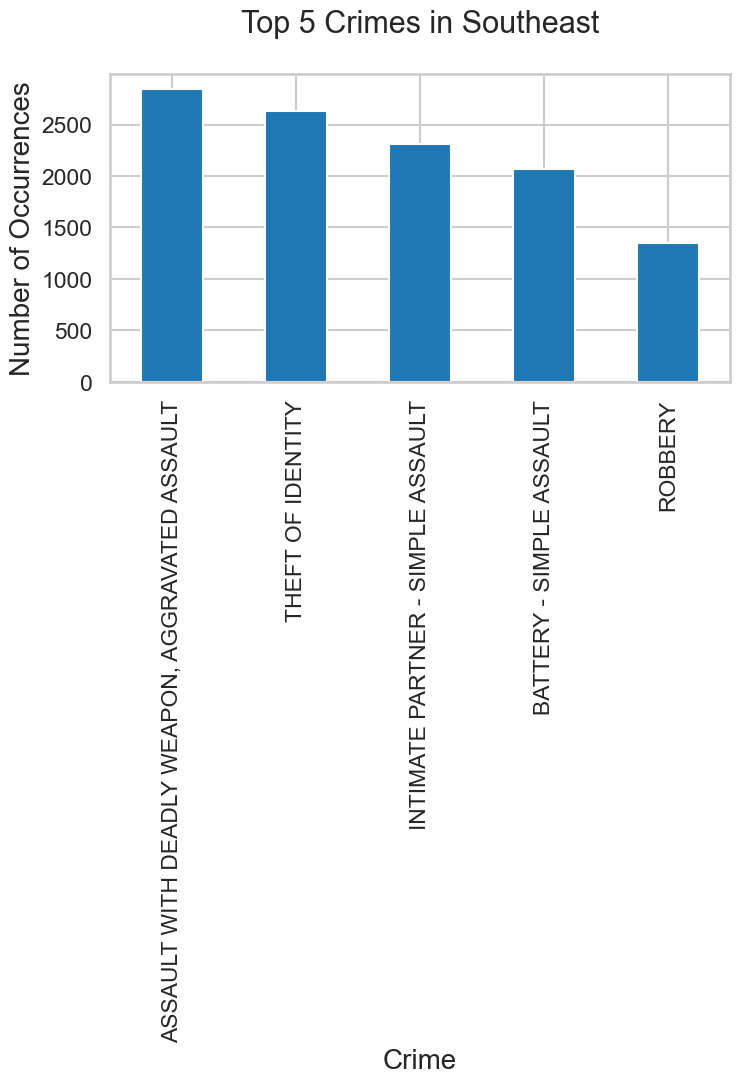

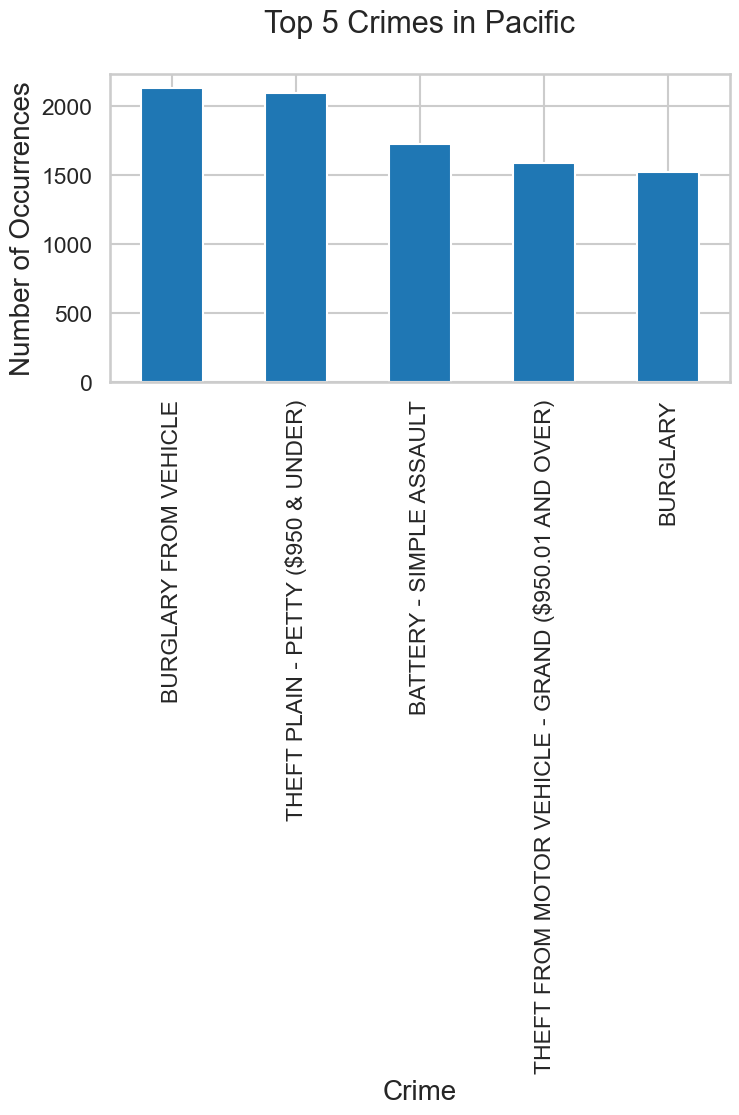

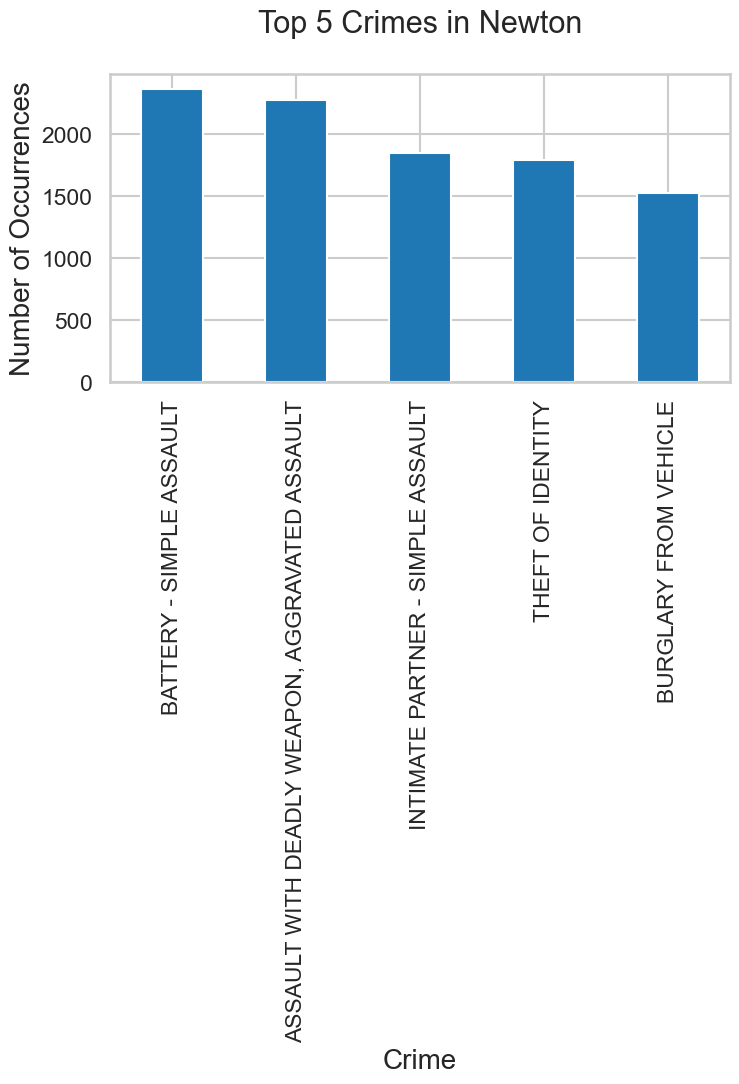

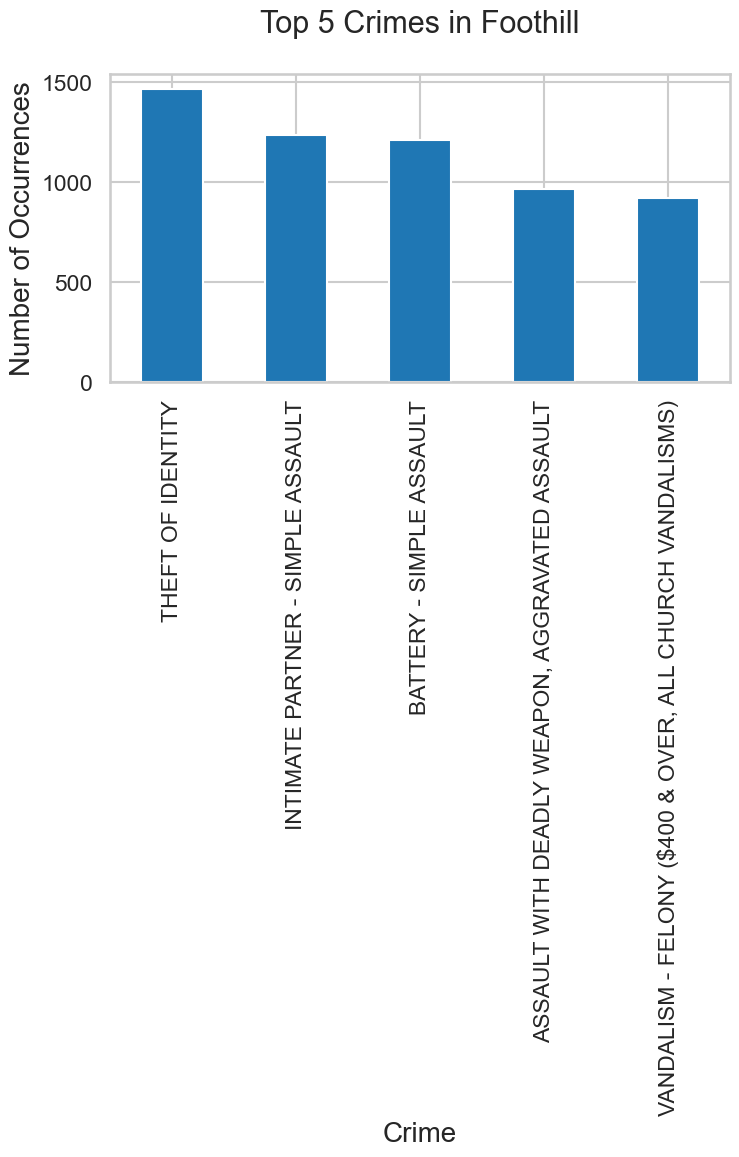

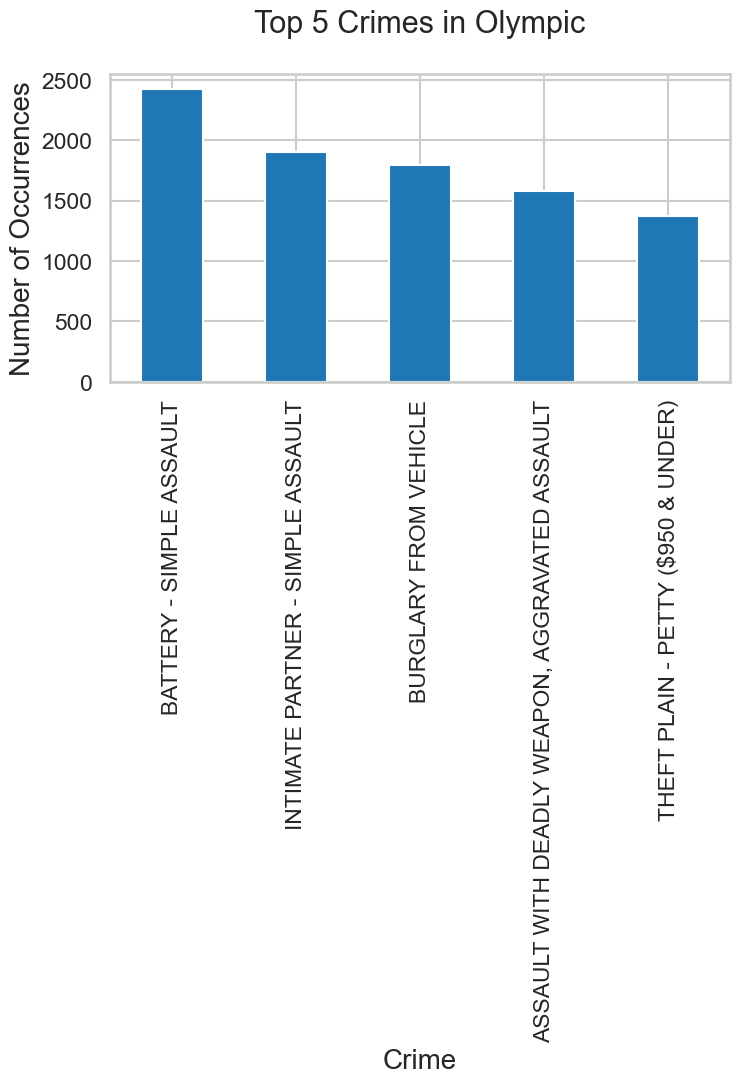

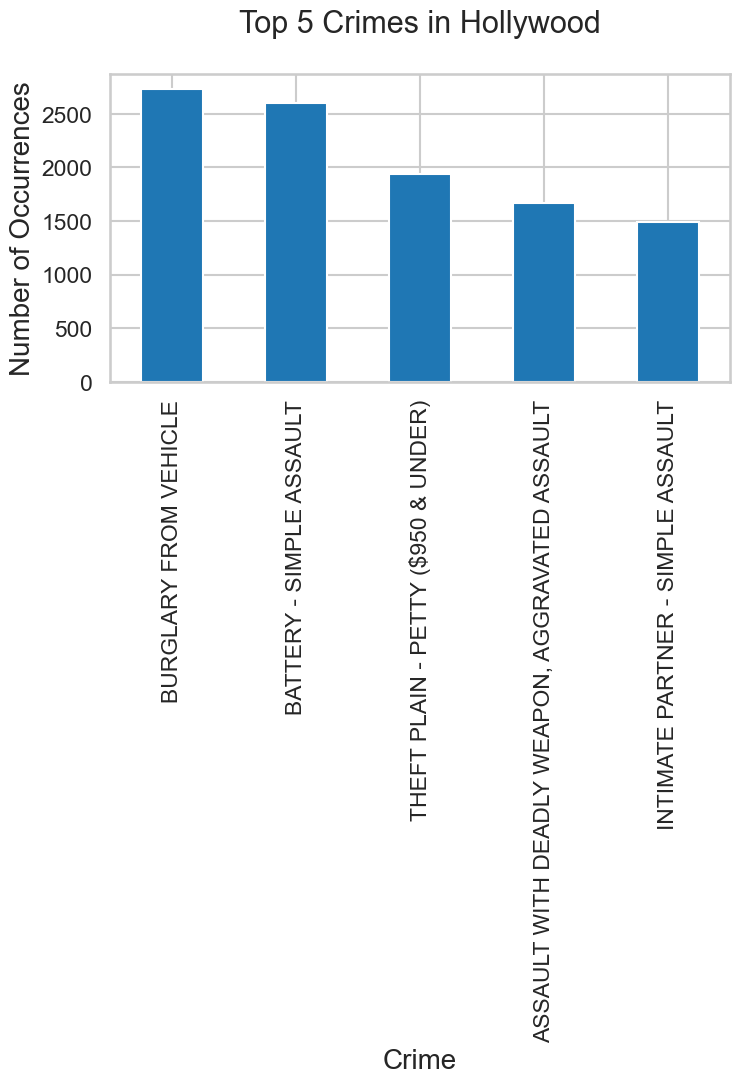

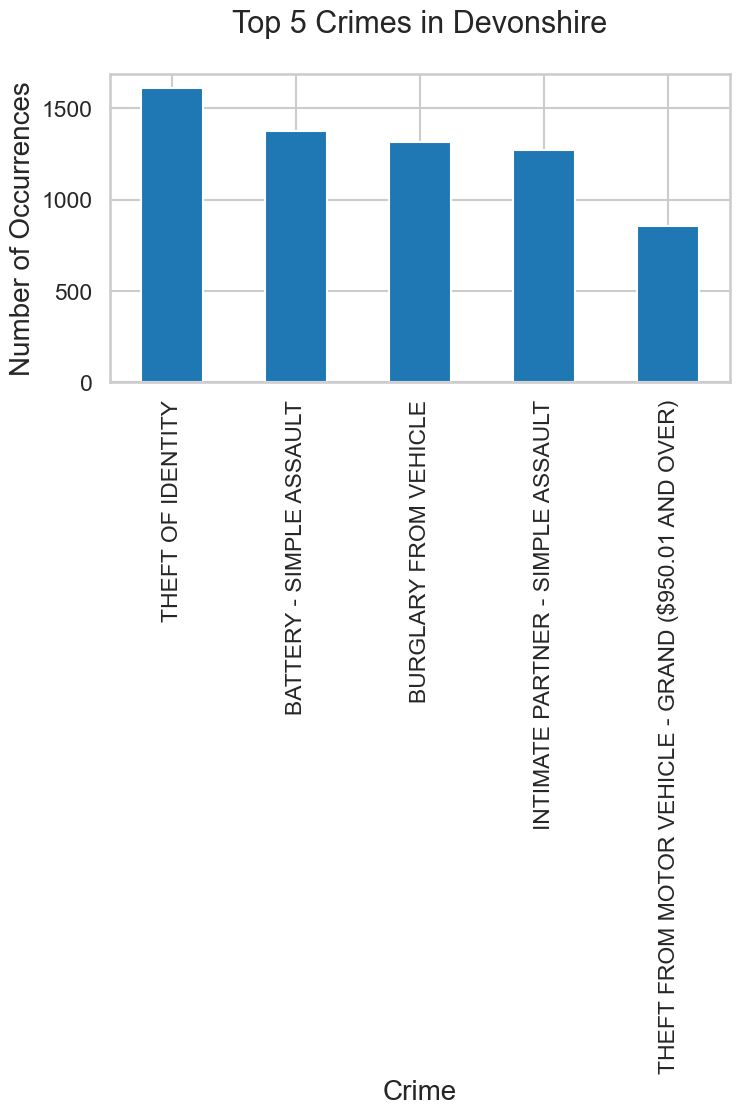

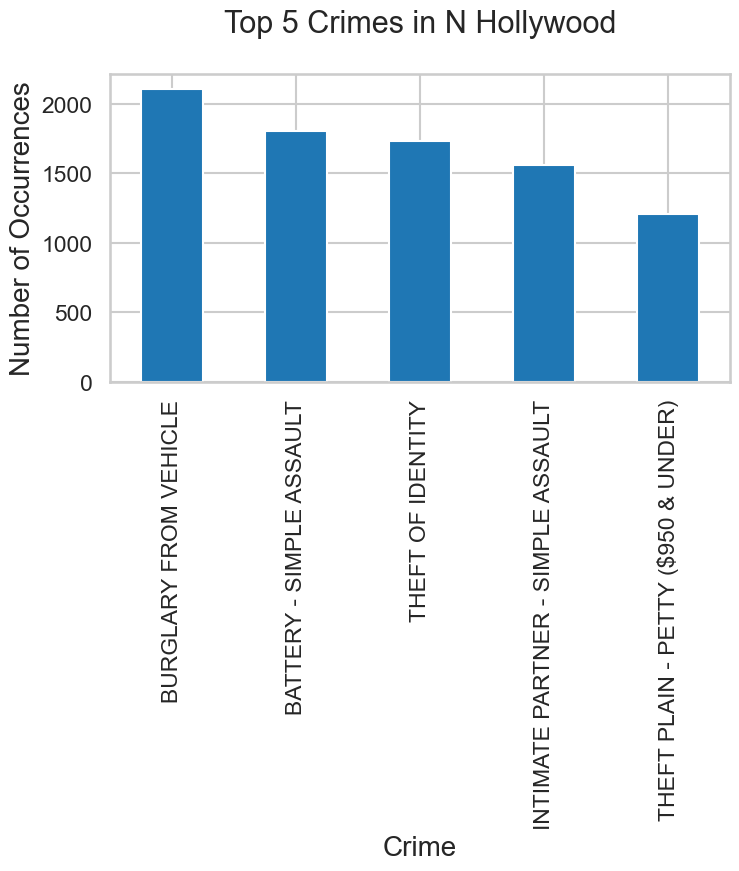

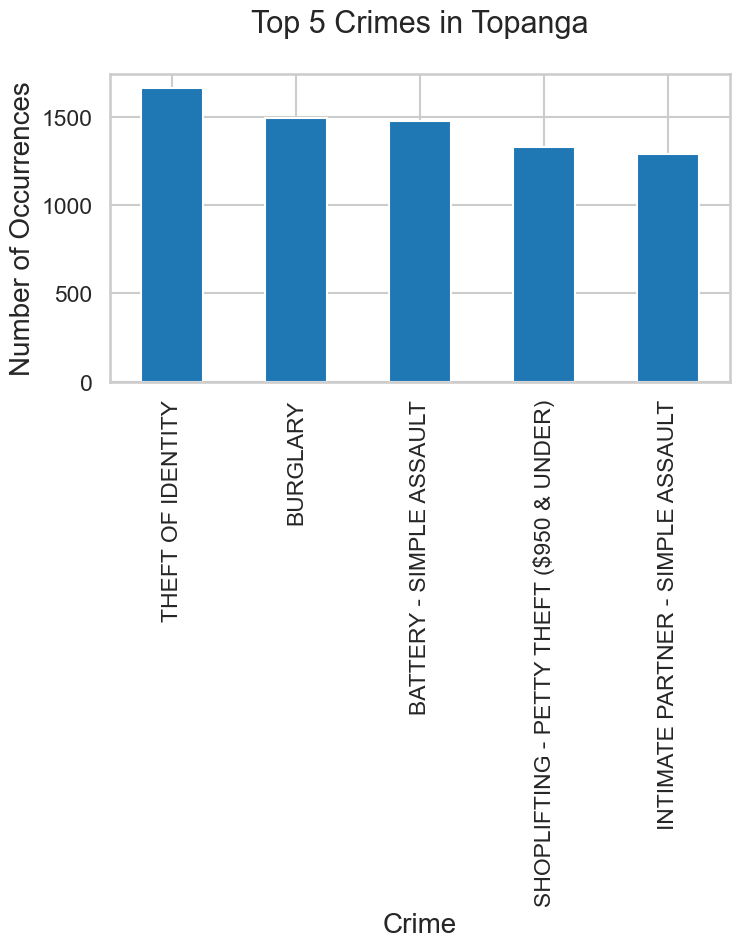

In [73]:
# Group by 'Area' and get value counts for 'crime_commited'
area_crime_counts = cd.groupby('Area')['crime_commited'].value_counts()

# Loop through each area and create a bar chart showing the top 5 crimes
for area in cd['Area'].unique():
    area_crime_counts.loc[area].nlargest(5).plot(kind='bar', figsize=(8,4))
    plt.title(f"Top 5 Crimes in {area}")
    plt.xlabel("Crime")
    plt.ylabel("Number of Occurrences")
    plt.show()

# That would give you an Overview at what exact location what crime happend

In [ ]:
"""
import folium
from folium.plugins import MarkerCluster

# get the latitude, longitude and crime_commited columns
d = cd[['LAT', 'LON', 'crime_commited']]

# get the top 5 most common crimes
top5_crimes = d['crime_commited'].value_counts().nlargest(5).index.tolist()

# filter the data frame to only include the top 5 crimes
d = d[d['crime_commited'].isin(top5_crimes)]

# create a map centered on Los Angeles
m = folium.Map(location=[34.0522, -118.2437], zoom_start=10)

# add markers for each crime location
marker_cluster = MarkerCluster().add_to(m)
for i, row in d.iterrows():
    popup_text = 'Crime: {}'.format(row['crime_commited'])
    marker = folium.Marker([row['LAT'], row['LON']], popup=popup_text)
    marker.add_to(marker_cluster)

# display the map
m
"""

# What Day has the highest Crime rate?

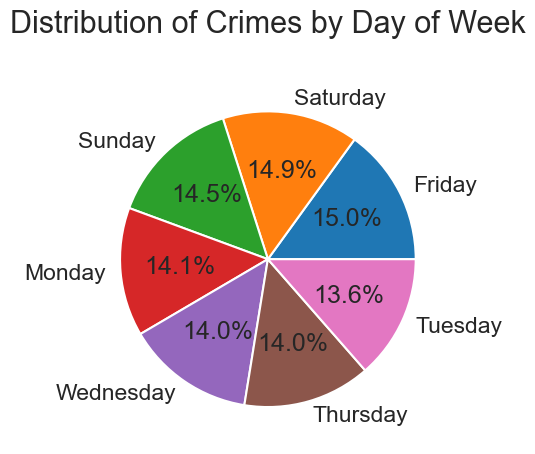

In [75]:
cd['Date'] = pd.to_datetime(cd['Date'], format='%Y-%m-%d')

# Extract day of week from Date column
cd['DayOfWeek'] = cd['Date'].dt.day_name()

# Get counts of crimes by day of week
crime_counts = cd['DayOfWeek'].value_counts()

# Plot a pie chart of the crime counts by day of week
plt.pie(crime_counts, labels=crime_counts.index, autopct='%1.1f%%')
plt.title("Distribution of Crimes by Day of Week")
plt.show()

# What Month has the Highest Crime rate?

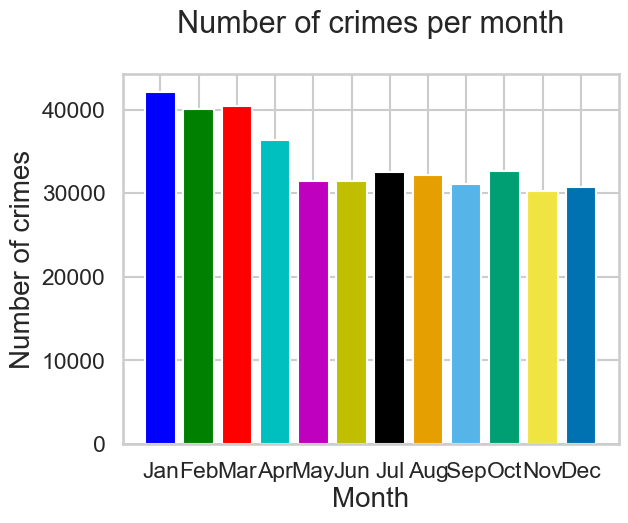

In [76]:
crimes_per_month = cd.groupby(cd['Date'].dt.month).size()

# Set x-axis labels and colors
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

# Create bar chart
plt.bar(month_names, crimes_per_month, color=colors)

# Set chart title and axis labels
plt.title('Number of crimes per month')
plt.xlabel('Month')
plt.ylabel('Number of crimes')


# Show chart
plt.show()

In [92]:
Q1 = np.percentile(crimes_per_month, 25)
Q1_first_quarter = np.percentile(np.concatenate([crimes_per_month[:3]]), 25)
pct_increase = (Q1_first_quarter - Q1) / Q1 * 100

print("Percentage increase: ", pct_increase)

Percentage increase:  28.35285108012381


# What Ethnicy is most affected?

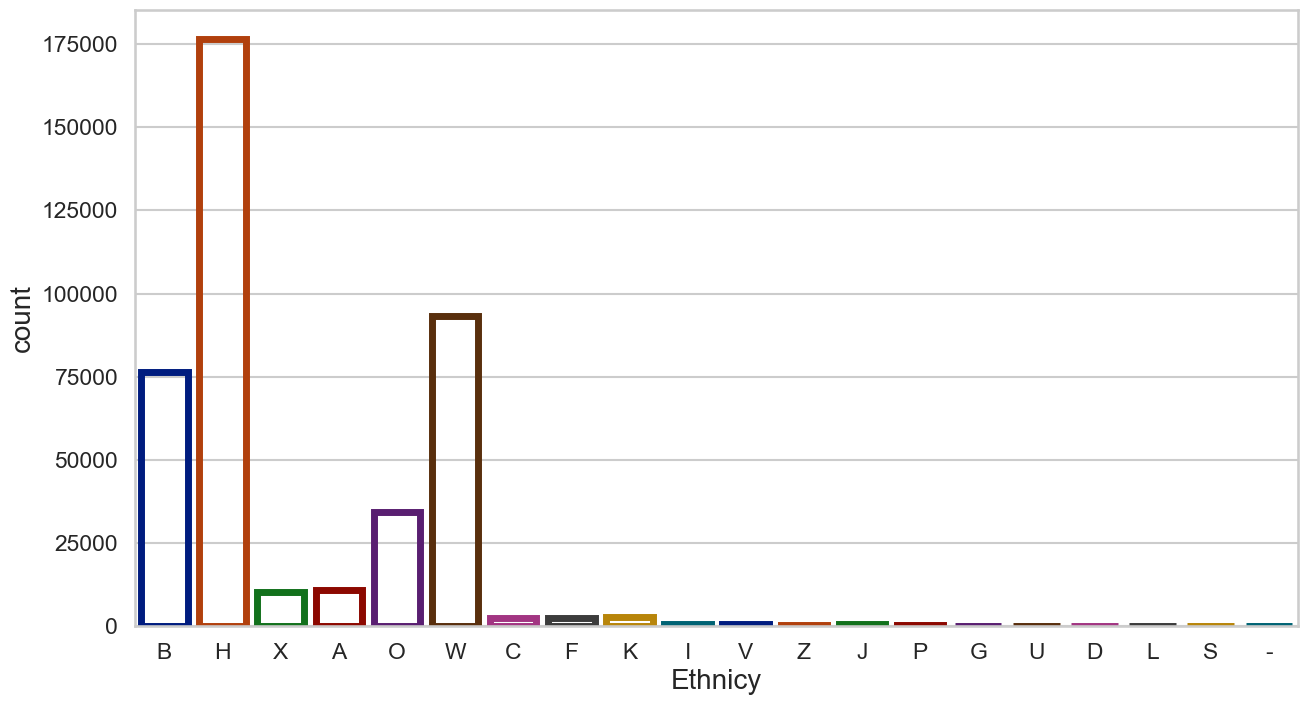

In [77]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x="Ethnicy", data=cd,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 24))

In [78]:
cd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411516 entries, 0 to 411515
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            411516 non-null  datetime64[ns]
 1   Area            411516 non-null  object        
 2   crime_commited  411516 non-null  object        
 3   Victim_age      411516 non-null  int64         
 4   Victim_sex      411516 non-null  object        
 5   Ethnicy         411516 non-null  object        
 6   LAT             411516 non-null  float64       
 7   LON             411516 non-null  float64       
 8   DayOfWeek       411516 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 28.3+ MB


In [79]:
cd['Victim_age'].describe()

count    411516.000000
mean         33.070712
std           9.454343
min           9.000000
25%          26.000000
50%          33.000000
75%          40.000000
max          51.000000
Name: Victim_age, dtype: float64

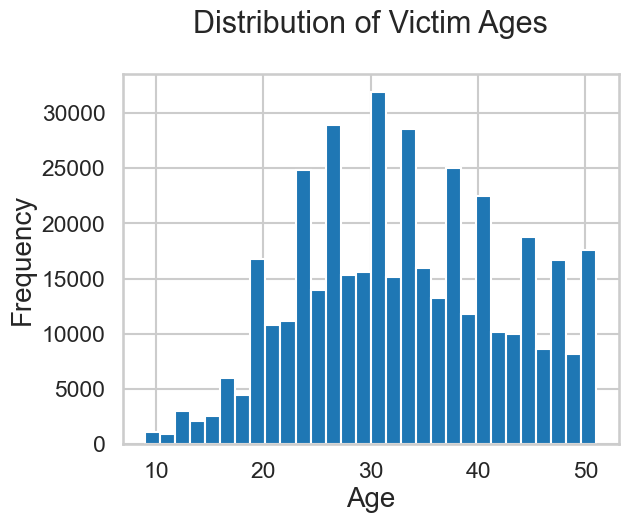

In [80]:
plt.hist(cd['Victim_age'], bins=30)

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Victim Ages')

# Show plot
plt.show()

# Making Age-bins

In [81]:
age_bins = [0, 20, 25, 30, 35, 40, 50,]

cd['Agebins'] = pd.cut(cd['Victim_age'], bins=age_bins)

In [82]:
def uniplot(df,col,title,hue =None):
    
    sns.set_style('whitegrid')
    sns.set_context('talk')
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams['axes.titlesize'] = 22
    plt.rcParams['axes.titlepad'] = 30
    
    
    temp = pd.Series(data = hue)
    fig, ax = plt.subplots()
    width = len(df[col].unique()) + 7 + 4*len(temp.unique())
    fig.set_size_inches(width , 8)
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.title(title)
    ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue,palette='bright') 
        
    plt.show()

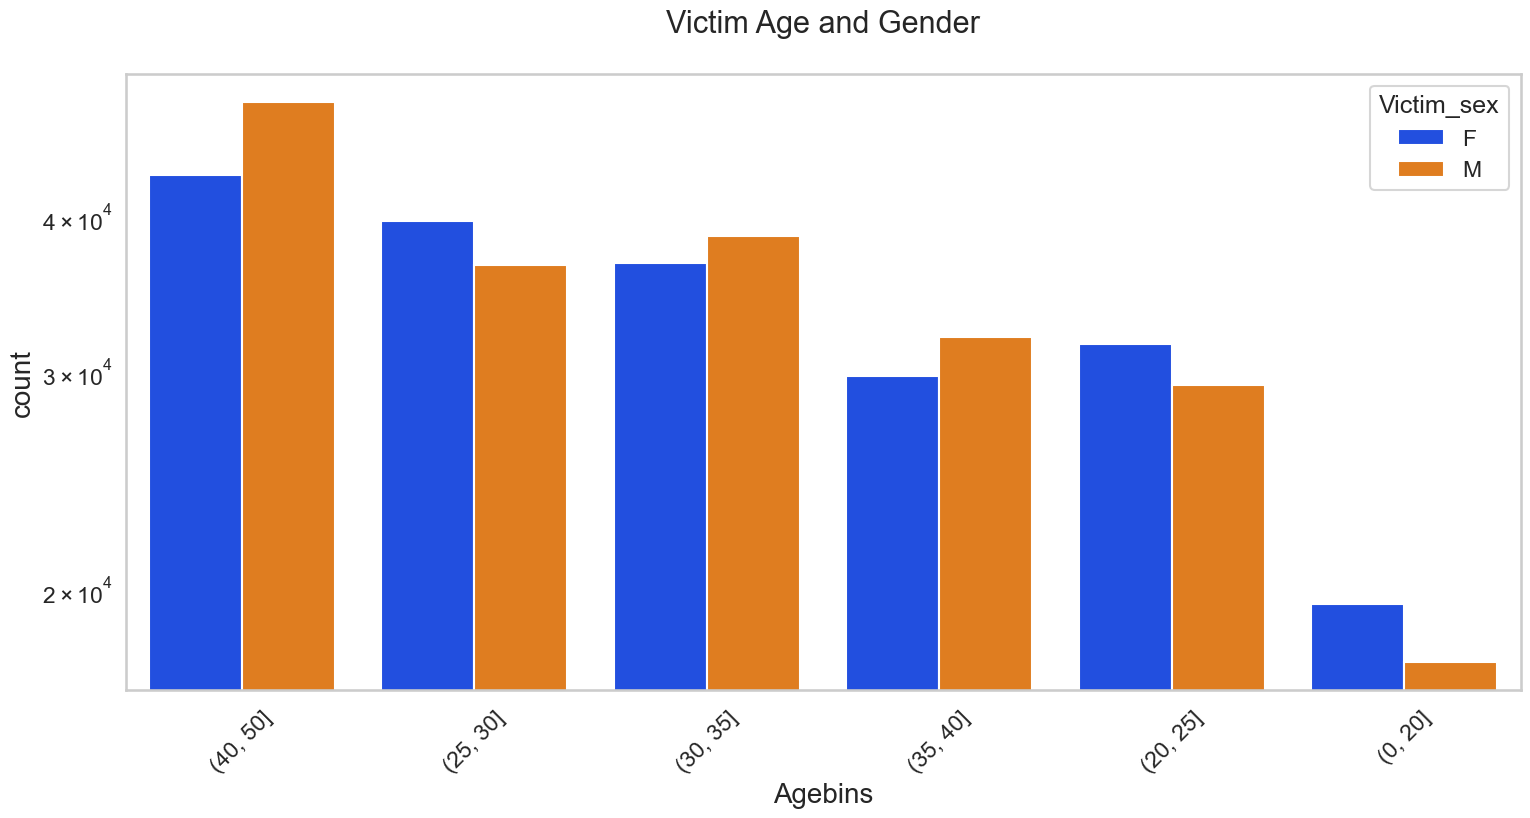

In [84]:
uniplot(cd,col='Agebins' ,title='Victim Age and Gender',hue='Victim_sex')

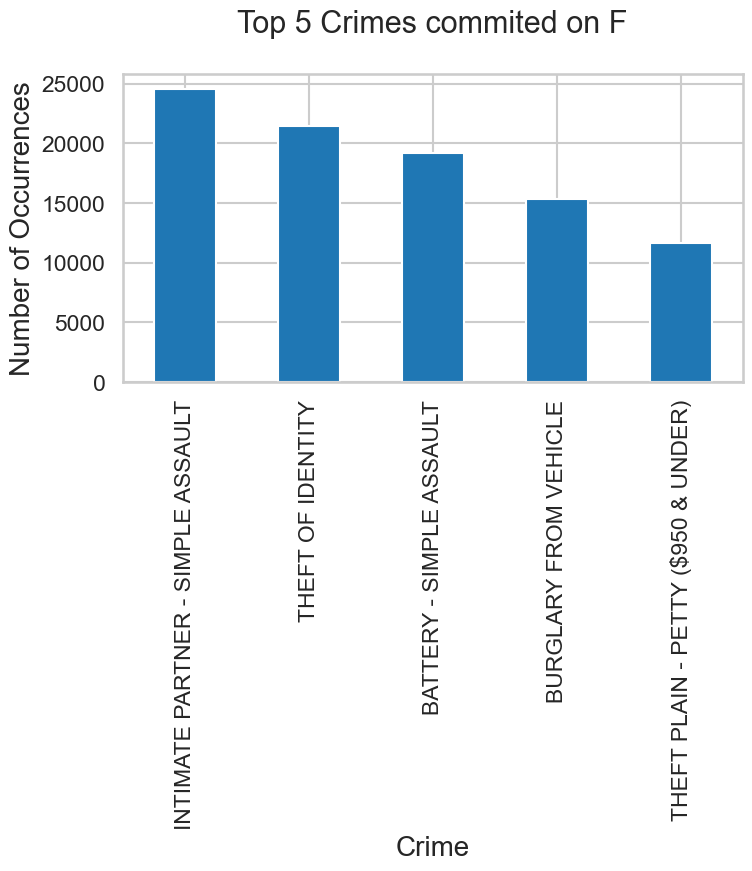

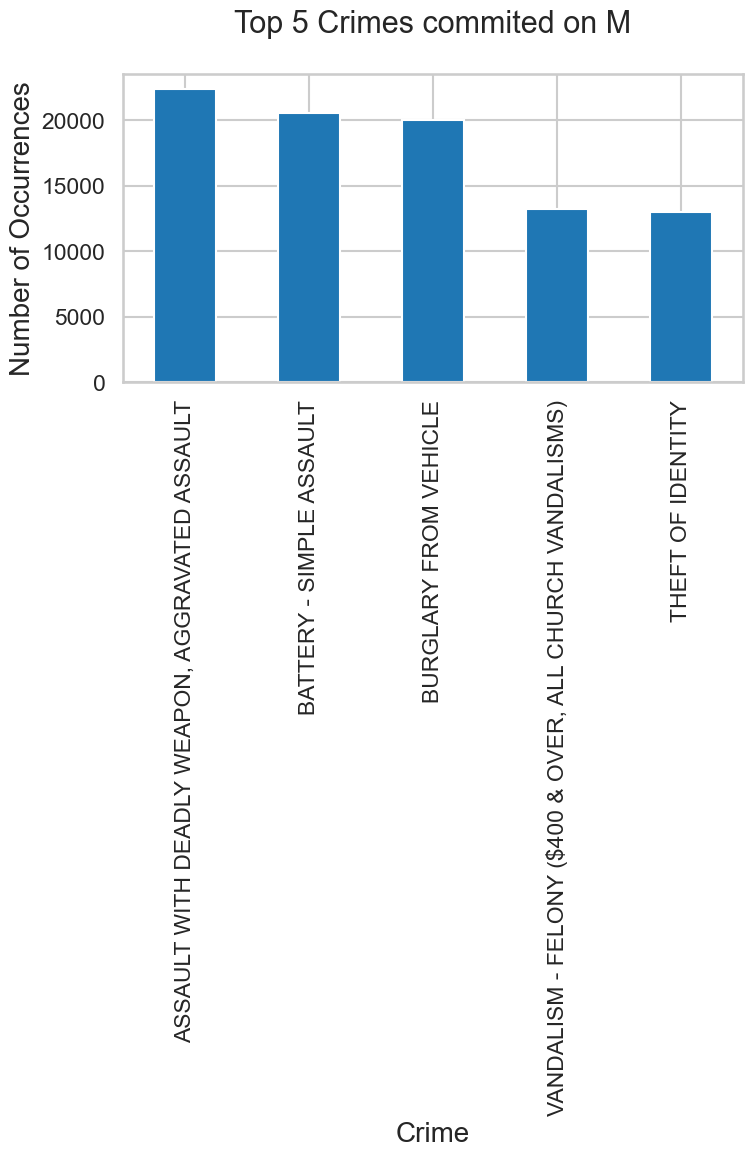

In [87]:
crime_counts = cd.groupby('Victim_sex')['crime_commited'].value_counts()

for crime in cd['Victim_sex'].unique():
    crime_counts.loc[crime].nlargest(5).plot(kind='bar', figsize=(8,4))
    plt.title(f"Top 5 Crimes commited on {crime}")
    plt.xlabel("Crime")
    plt.ylabel("Number of Occurrences")
    plt.show()

# Conclusion

-The three most dangerous parts of the city are: Centra, Southwest, and 77th Street.

-The three most common crimes in the city are: Battery - Simple Assault, Burglary from Vehicle, and Theft of Identity.

-Friday has the highest crime rate out of all days of the week.

-Males are most likely to become a victim at the age of 30-50, while females are more likely to become a victim at the age of 0-30.

-Males are most likely to fall victim to Assault with Deadly Weapon and Aggravated Assault, while females are most likely to fall victim to Intimate Partner - Simple Assault.

-January is the month with the highest crime rate, and the first quartile of the year has 28.35% more crime than the rest of the year on average.